In [1]:
import os 
import tarfile
from six.moves import urllib
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

# Warning: Since Scikit-Learn 0.20, the sklearn.preprocessing.Imputer class was replaced by the sklearn.impute.SimpleImputer class.
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer
    
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline

try:
    from sklearn.compose import ColumnTransformer
except ImportError:
    from future_encoders import ColumnTransformer # Scikit-Learn < 0.20

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score

## Import the Data

In [2]:
# https://github.com/ageron/handson-ml

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, 
                       housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

## Data Structure

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


The data is likely symmetrically distributed (the data is not skewed) about the mean/median for the housing median age.  

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

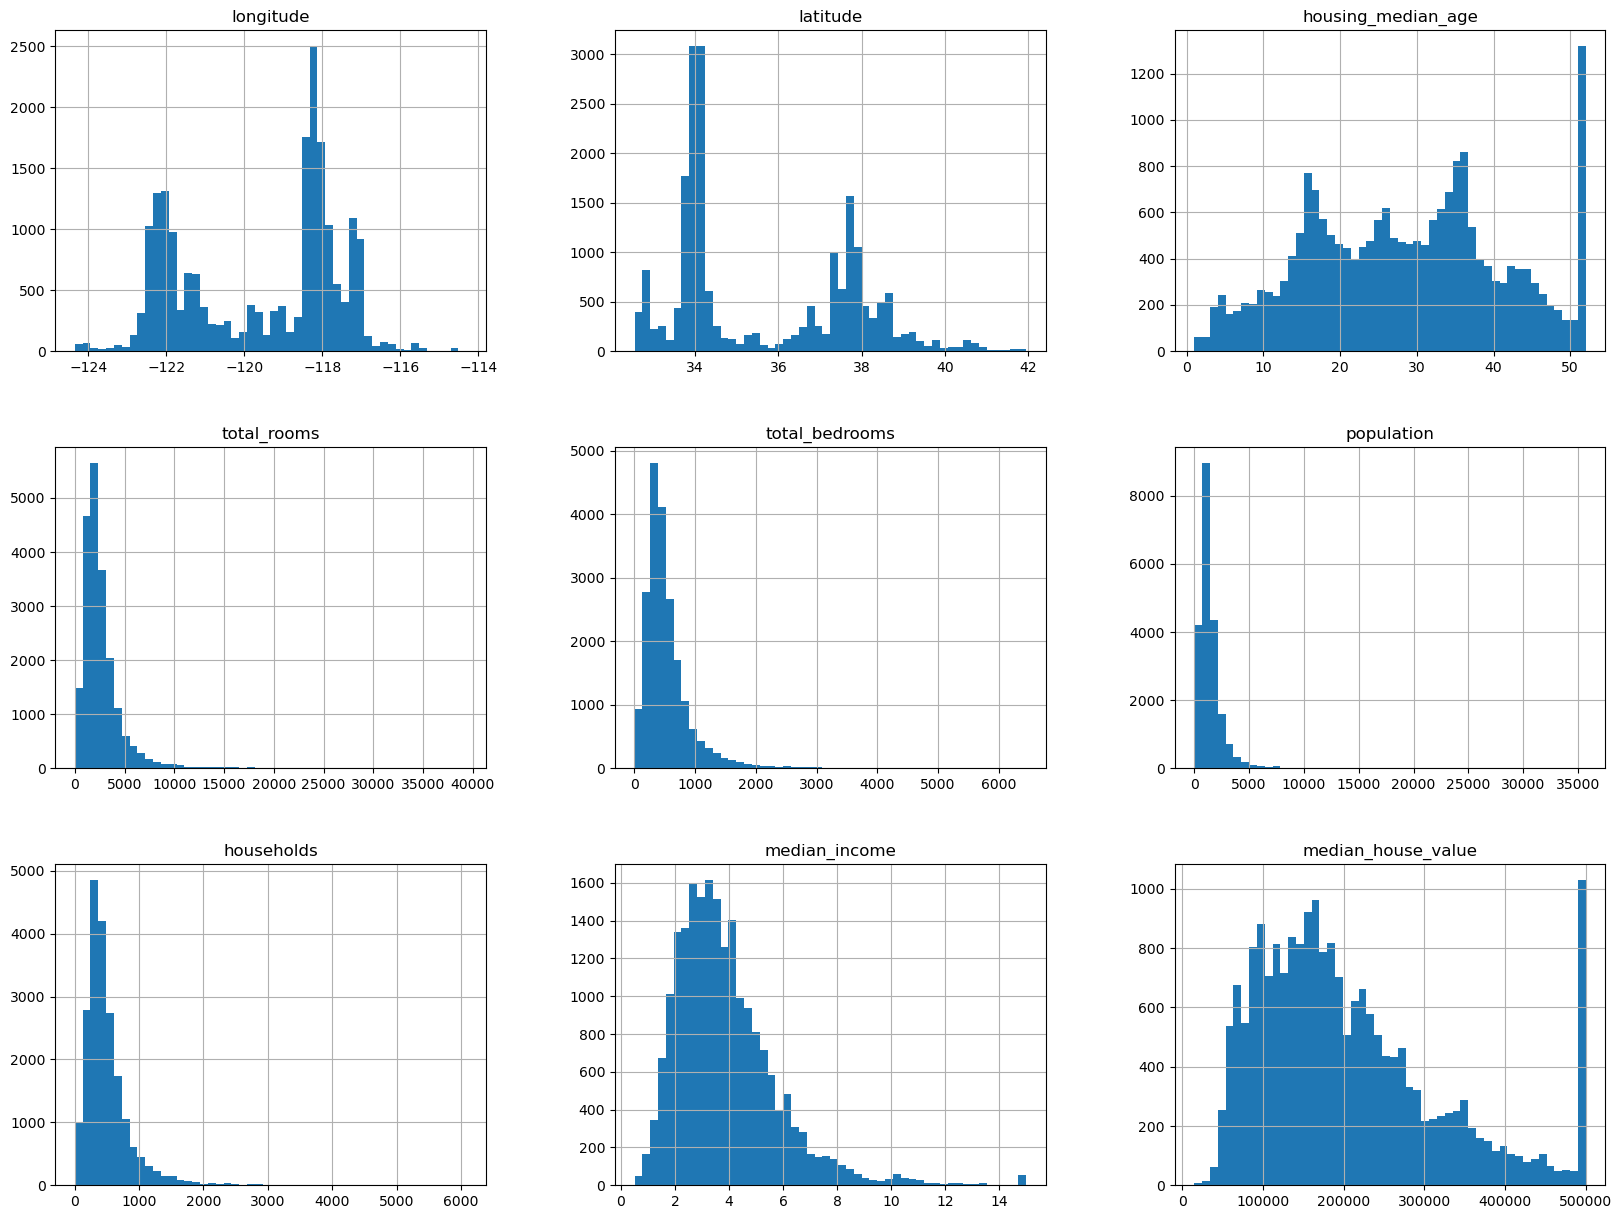

In [10]:
housing.hist(bins=50, figsize=(20,15))

1. median income is not expressed in US dollards (15 for higher median incomes and 0.5 for lower median incomes)
2. housing median age has been capped (limited) to 50.0001 years old
3. the median house value has been capped (limited) to 500000.01
    * check with yout team or client to double check if this is prolem or not  
    * TODO: if they tell me that they need precise predictions even for above 500,000.01 then:
        * collect proper labels for values above 500,000.01
        * remove those values above 500,000.01
4. Many histograms from above are skewed to right or to the left, this could make harder for machine learning models to detect patterns; 
    * therefore, I have to transform these attributes to have a more bell-shaped distributions.

## Create a Test Set

Large datasets can be cumbersome to process, especially on standard personal computers. A well-chosen representative subset can significantly speed up computations, making preliminary analyses faster and more interactive.

By working with a smaller, but representative subset, you can better understand the distributions, relationships, and potential anomalies in your data without getting overwhelmed.

Not all systems have the capacity to handle large datasets. By sampling a representative subset, you can still perform meaningful analyses without the need for specialized big data tools or infrastructure.

#### Data Snooping Bias
Human's brain are an amazing pattern decision system, which means that it is highly prone to **overfitting**. By looking at test set, we could encounter a pattern (that could be due to random chance) and use this pattern in our machine learning model because for that particular data set we are getting great results in our model, but when looking at more data we encountered that our model is not performing well. This is called **data snooping bias**

In [11]:
# note: random_state=42 generates a seed 
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

**stratified sample** let's say that for example, the US population is 51.3% female and 48.7% male, so a well conducted survey of the US would try to maintain this ratio in the sample: 513 female and 487 male in a survey of 1000 people. We are basically dividing the data into subgroups called strata.

Let's assume that it is given that the **median income** is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. 

<AxesSubplot:>

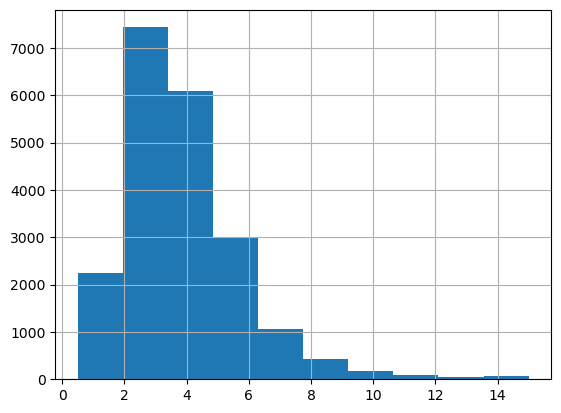

In [12]:
housing["median_income"].hist()

In [13]:
housing["median_income"].value_counts()

3.1250     49
15.0001    49
2.8750     46
2.6250     44
4.1250     44
           ..
4.0774      1
4.1767      1
6.1814      1
6.4319      1
2.0943      1
Name: median_income, Length: 12928, dtype: int64

It is important to have sufficient number of isntances in the dataset for each stratum (In this case, the stratum or subgroups are the median_income), or elase the estimate of the stratum's importance may be biased. This means that you should **not have too many strata, and each starta should ne large enough**. 

The following code creates an income **category** attribute by dividing the median income by 1.5 (to limit the number of income categories)

In [14]:
# note: np.ceil is like a ceilling function which round numbers up to have discrete categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"]

0        6.0
1        6.0
2        5.0
3        4.0
4        3.0
        ... 
20635    2.0
20636    2.0
20637    2.0
20638    2.0
20639    2.0
Name: income_cat, Length: 20640, dtype: float64

<AxesSubplot:>

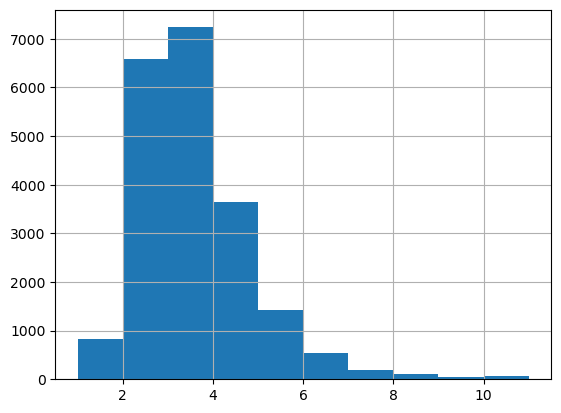

In [15]:
housing["income_cat"].hist()

To limit the number of income categories, we can also merge together all the categories that are greater than 5 together. 

In [16]:
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)
housing["income_cat"]

0        5.0
1        5.0
2        5.0
3        4.0
4        3.0
        ... 
20635    2.0
20636    2.0
20637    2.0
20638    2.0
20639    2.0
Name: income_cat, Length: 20640, dtype: float64

In [17]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

<AxesSubplot:>

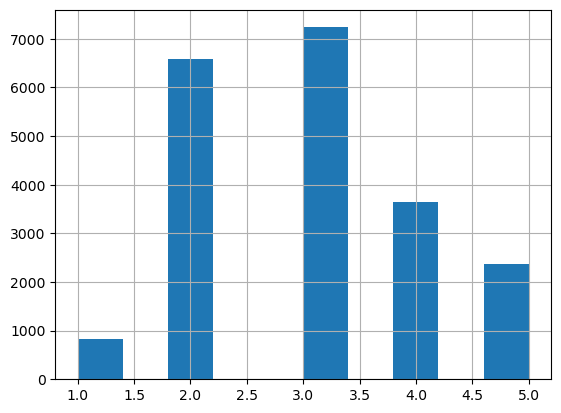

In [18]:
housing["income_cat"].hist()

The following code is the proportion of the each category in the entire data set. 

Note: the goal is to keep this same proportion in the training set 

In [19]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

The Following code stratified sampling based on the income category:

In [20]:
# For many model validation techniques, such as k-fold cross-validation, n_splits would typically 
# be greater than 1, as you would be splitting the data multiple times to validate your model's 
# performance on different subsets of the data. Each split would produce a new train/test combination.

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [21]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114341
1.0    0.039971
Name: income_cat, dtype: float64

The following code let us compare the proportion of the full dataset, with the stratified test dataset and the random test data set

In [22]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

# random test dataset
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

# compare proportions:
compare_props = pd.DataFrame({
    "Full Data Set": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

compare_props

,Full Data Set,Stratified,Random
1.0,0.039826,0.039971,0.040213
2.0,0.318847,0.318798,0.324370
3.0,0.350581,0.350533,0.358527
4.0,0.176308,0.176357,0.167393
5.0,0.114438,0.114341,0.109496


* The test set generated using stratified sampling has income category proportions almost identifcal to those in the full data set 
* whereas the test set generated using purely random sampling is quite skewed.

In [23]:
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Full Data Set"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Full Data Set"] - 100

compare_props

,Full Data Set,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039971,0.040213,0.973236,0.364964
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.176308,0.176357,0.167393,-5.056334,0.027480
5.0,0.114438,0.114341,0.109496,-4.318374,-0.084674


Remove the income_cat attribute so the data is back to its original state:

In [24]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

## Discover and Visualize the Data to gain Insights

let's only look at the stratified trainning set of our since as shown befpre it offers a good representation of the data
* if the training set is very large, you may want to sample an exploration set, to make manipulation easy and fast. 
* In this case the training set is quite smalle, so we can proceed with the training set.

In [25]:
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

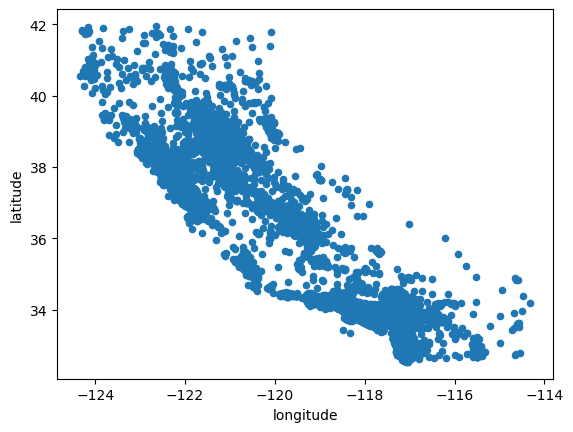

In [26]:
housing.plot(kind="scatter", x="longitude", y="latitude")

Setting the Alpha option to 0.1 makes it much easier to visualize the place where there is a high density of data points

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

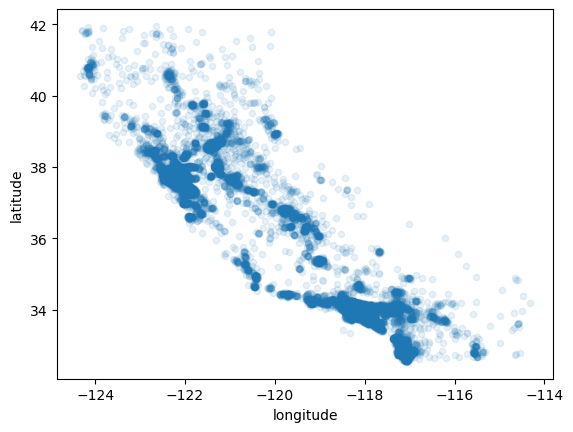

In [27]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

High-density areas:
* Bay Area 
* Los Angeles
* San Diego

A Long line of fairly high density:
* Central Valley
* Sacramento
* Fresno

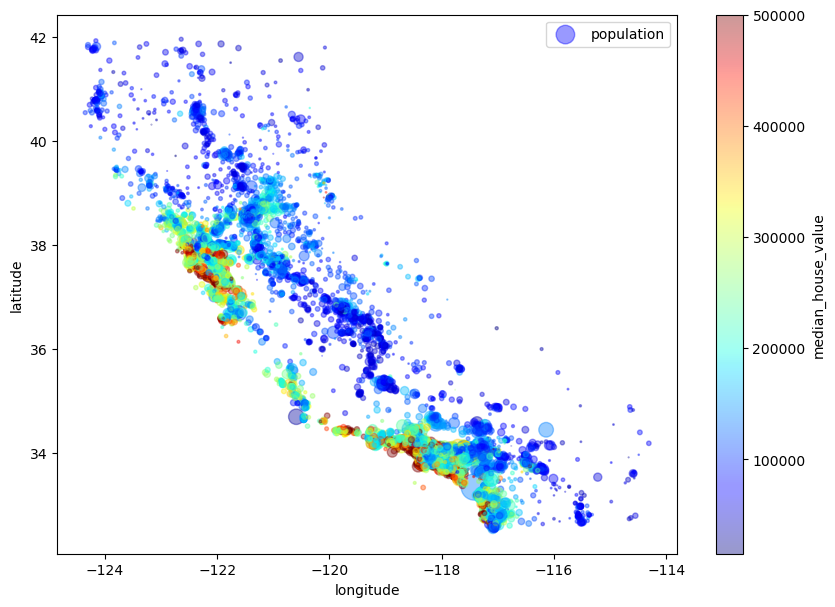

In [28]:
# option 's': makes the size of each point correspond to values in the selected column.
# option 'c': colors each point based on values in the the selected column, with the actual colors determined by the 'jet' colormap

# The code snippet cmap=plt.get_cmap("jet") retrieves a colormap from the matplotlib library, this color map is 'jet'

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7), # Radius of each circle: represent Population
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, # Color of each circle: represent House Value
    sharex=False)
plt.legend()

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density. 

Notes: It will proabbly be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the approximity of the cluster centers. 
* the ocean aproximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule

### Looking for Correlations 

In [29]:
# Pearson's Correlation (r)
# Correlation coefficients ranges between -1 and 1
# values close to 1 or -1 means that there is a strong positive or negative correlation
# positive: as one value goes up the other goes up
# negative: as one value goes up the other goes down

# note: The correlation coefficient only measures linear correlations ("if x foes up, then y generally goes up/down")
# remenber that there could be non-linear relationships that are very high correlated but since they are non-linear
# the Pearson's Correlation could give the this correlation a value of zero

corr_matrix = housing.corr()

# Let's look at how much each attributes correlates with median_house_value:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

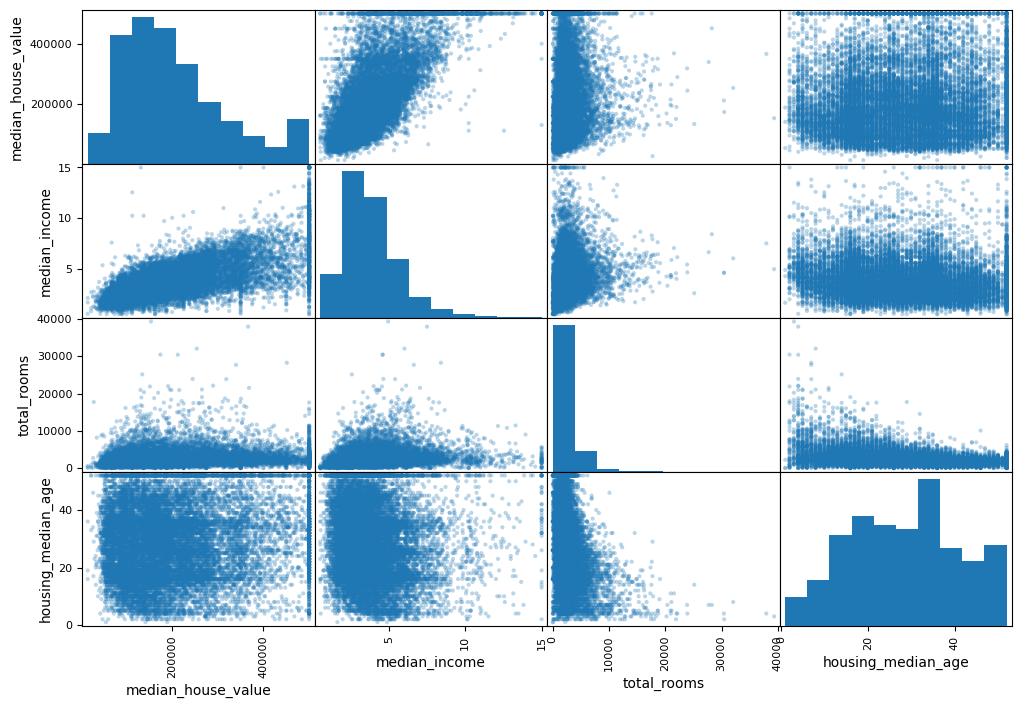

In [30]:
attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize=(12, 8), alpha=0.3)

The most promissing attribute to predict the median house vlaue is the median income, so let's zoom mean in their correlation scatter plot

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

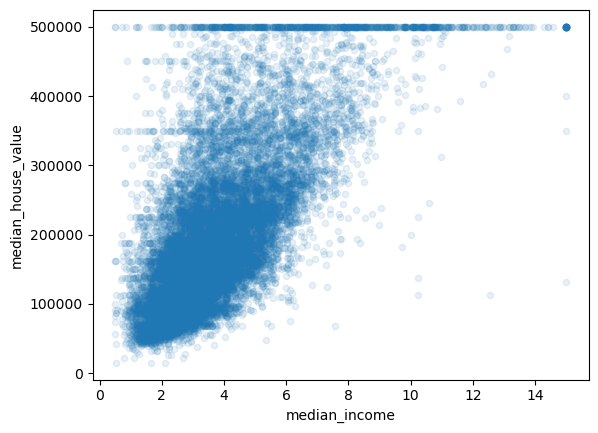

In [31]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

This plot reveals a few things:
* The correlation is indeed very strong (positive correlation)
* We can noticed the price cap is clearly visble as a horizontal line at 500k.
* Other less obvious straight lines: horizontal lines around 450k another around 350k and another one at 280k

You may want to try **removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks** (unexpected patterns, anomalies, or characteristics in a dataset)

I also noticed that ome attributes have a **tail-heavy distribution**, so you may want to **transform** them (e.g., by computing their logarithm). 

### Experimenting with Attribute Combinations

Before preparing the data for Machine Learning algortihms we should try out various attribute combinations.

For example, the total number of rooms in a district is not very useful if you don't know how many households there are. What you really want is the number of rooms per household. Similarly the total number of bed rooms and the total population. 

In [32]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [33]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

Notices how bedrooms per room attribute is more correlated (negatively) with the median house value than the total number of rooms or bedrooms. Meaning that the houses with a lower bedroom/ratio tend to be more expensive.

The number of rooms per household is also slightly more informative than the total number of rooms. 

<AxesSubplot:xlabel='rooms_per_household', ylabel='median_house_value'>

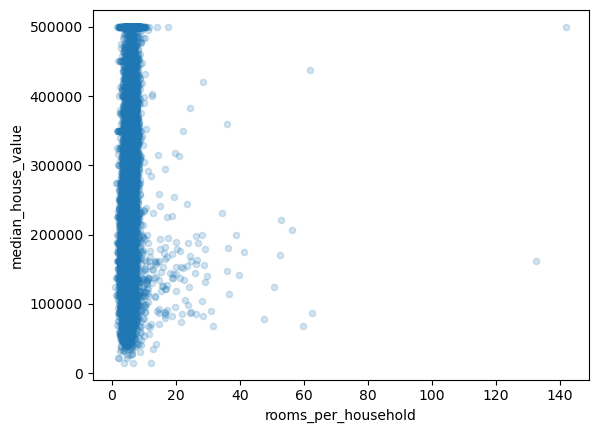

In [34]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value", alpha=0.2)

In [35]:
np.trunc(housing["rooms_per_household"]).value_counts()

5.0      5190
4.0      4658
6.0      2750
3.0      1937
7.0      1014
8.0       340
2.0       338
9.0        76
10.0       38
1.0        28
11.0       21
16.0       12
14.0       11
12.0       11
13.0        7
17.0        6
26.0        6
24.0        6
15.0        6
19.0        6
18.0        5
22.0        5
28.0        5
20.0        5
23.0        4
21.0        4
36.0        4
29.0        3
52.0        2
31.0        2
41.0        1
47.0        1
50.0        1
62.0        1
34.0        1
39.0        1
59.0        1
38.0        1
132.0       1
141.0       1
56.0        1
61.0        1
Name: rooms_per_household, dtype: int64

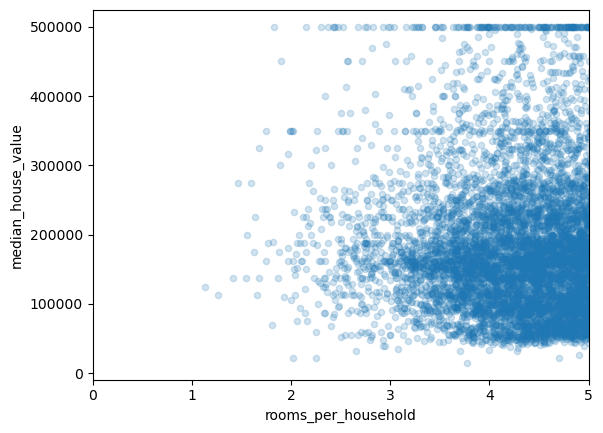

In [36]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value", alpha=0.2)

plt.xlim([0,5])
plt.show()

In [37]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


## Prepare the Data for Machine Learning Algorithms 

Separate the predictors and the labels since we don't want to apply the same transformations to the predictors and the target values.

In [38]:
housing = strat_train_set.drop("median_house_value", axis=1) # predictors 
housing_labels = strat_train_set["median_house_value"].copy() # the target label

In [39]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN


In [40]:
housing_labels.head()

12655     72100.0
15502    279600.0
2908      82700.0
14053    112500.0
20496    238300.0
Name: median_house_value, dtype: float64

## Data Cleanning

### Missing values from Numerical Attributes 

Most Machine Learning ALgorithms don't perform well with missing values (null), so let's create a few functions to take care of them.

You noticed earlier that the total_bedrooms attribute has some missing values, so let's fix this. You have three options:
* **option 1:** Get rid of the corresponding districts
* **option 2:** Get rid of the whole attribute
* **option 3:** Set the values to some value (zero, mean, median, etc.).
    * For this option, you need to save the mean or median to a variable because you will need this for later to approximate values in the test set

In [41]:
# housing.dropna(subset=["total_bedrooms"])    # option 1
# housing.drop("total_bedrooms", axis=1)       # option 2

# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True) # option 3

There is a **4th option** that is safer for dealing with **null** values. We used **Imputer** from Scikit-Learn to replace **all** null numericals value with the Median, Mean, a constant value or most frequent value. 

In [42]:
imputer = SimpleImputer(strategy="median")

# Remove the text attribute because median can only be calculated on numerical attributes:
housing_num = housing.drop('ocean_proximity', axis=1) # drop ocean_proximity column
# alternatively: housing_num = housing.select_dtypes(include=[np.number])

In [43]:
# fit the imputer instance to the training data using the fit() method:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [44]:
# this contains all the median values of housing_num
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [45]:
housing_num.median()

longitude             -118.51000
latitude                34.26000
housing_median_age      29.00000
total_rooms           2119.00000
total_bedrooms         433.00000
population            1164.00000
households             408.00000
median_income            3.54155
dtype: float64

In [46]:
# Transform the training set:
X = imputer.transform(housing_num) 

# the result of X is a simple plain numpy array, if you want to put it back into a Pandas Data Frame:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,index=housing.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


In [47]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


Notices, no more non-null values is this transformed training dataset

### Handling Text and Categorical Attributes

Most Machine Learning Algorithms prefer to work with numbers anyway, so let's convert these text labels to numbers.

In [48]:
housing_cat = housing[["ocean_proximity"]] # Only take categorical attributes

In [49]:
encoder = LabelEncoder()
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

/Users/elian/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([1, 4, 1, ..., 0, 0, 1])

In [50]:
np.unique(housing_cat_encoded)

array([0, 1, 2, 3, 4])

This is better because now we can use this numerical data in any ML algorithm 

In [51]:
# to look at the mapping that this encoder has learned: 
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)

One **issue** with this representation is that ML algortihms will assume that two nearby values are more similar than two distant values. Obviously this is not the case
* For Example: categories 0 and 4 are more similar than categories 0 and 1.

**One Hot Encoder**: To **fix** this **issue**, a common solution is to create one binary attribute per category
* One Attribute equal to 1 when the category is <1H OCEAN and 0 otherwise
* One Attribute equal to 1 when the category is INLAND and 0 otherwise
* One Attribute equal to 1 when the category is ISLAND and 0 otherwise
* One Attribute equal to 1 when the category is NEAR BAY and 0 otherwise
* if all the Attribute value of each category is equal to 0 than it is NEAR OCEAN

Note: OneHotEnconder enocoder from scikit-learn converts integer categorical values into one-hot vectors. 

In [52]:
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat) 
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

By default, the OneHotEncoder class returns a sparse array, but we can convert it to a dense array if needed by calling the toarray() method:

In [53]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [54]:
encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Alternatively, you can set sparse=False when creating the OneHotEncoder:

In [55]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [56]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### Custome Transformers 

In [57]:
from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices for the specified columns: safer than hard-coding indices 
rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

# This is a custom transformer named CombinedAttributesAdder. Its primary purpose is to derive and add 
# new attributes to the dataset based on existing attributes.
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kwargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    # The fit method is trivial in this case; it just returns the instance itself (return self) since there's 
    # no "learning" needed for this transformer.
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    # The transform method is where the new attributes are computed and added. 
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        

# Here, an instance of the CombinedAttributesAdder is created with add_bedrooms_per_room set to False, 
# so the new attribute bedrooms_per_room will not be added.
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], dtype=object)

The Following code will turn the above numpy array back to a Pandas DataFrame with new attribtes for the added columns

In [58]:
# Original columns
columns_list = list(housing.columns)

# Add the new attributes' names
columns_list.extend(["rooms_per_household", "population_per_household"])

# Check if bedrooms_per_room attribute was added and append its name if it was
if attr_adder.add_bedrooms_per_room:
    columns_list.append("bedrooms_per_room")

# Convert the numpy array back to a DataFrame
housing_extra_attribs_col = pd.DataFrame(housing_extra_attribs, columns=columns_list, index=housing.index)
housing_extra_attribs_col

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241
...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.09,<1H OCEAN,6.658342,2.023976
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND,5.571932,3.363188
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN,4.110465,2.662791
19140,-122.7,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN,6.297405,2.411178


Alternatively, you can use Scikit-Learn's FunctionTransformer class that lets you easily create a transformer based on a transformation function. 
* Note that we need to set validate=False because the data contains non-float values (validate will default to False in Scikit-Learn 0.22).

In [59]:
from sklearn.preprocessing import FunctionTransformer

def add_extra_features(X, add_bedrooms_per_room=True):
    rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
    population_per_household = X[:, population_ix] / X[:, household_ix]
    if add_bedrooms_per_room:
        bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
        return np.c_[X, rooms_per_household, population_per_household,
                     bedrooms_per_room]
    else:
        return np.c_[X, rooms_per_household, population_per_household]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_bedrooms_per_room": False})
housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [60]:
housing_extra_attribs

array([[-121.46, 38.52, 29.0, ..., 'INLAND', 5.485835694050992,
        3.168555240793201],
       [-117.23, 33.09, 7.0, ..., 'NEAR OCEAN', 6.927083333333333,
        2.6236979166666665],
       [-119.04, 35.37, 44.0, ..., 'INLAND', 5.3933333333333335,
        2.223333333333333],
       ...,
       [-122.72, 38.44, 48.0, ..., '<1H OCEAN', 4.1104651162790695,
        2.6627906976744184],
       [-122.7, 38.31, 14.0, ..., '<1H OCEAN', 6.297405189620759,
        2.411177644710579],
       [-122.14, 39.97, 27.0, ..., 'INLAND', 5.477157360406092,
        3.1725888324873095]], dtype=object)

In [61]:
# Original columns
columns_list = list(housing.columns)

# Add the new attributes' names
columns_list.extend(["rooms_per_household", "population_per_household"])

# Check if bedrooms_per_room attribute was added by referencing the function's argument
# Here, we use the kw_args dictionary from the FunctionTransformer instance to check
if attr_adder.kw_args["add_bedrooms_per_room"]:
    columns_list.append("bedrooms_per_room")

# Convert the numpy array back to a DataFrame
housing_extra_attribs_col = pd.DataFrame(housing_extra_attribs, columns=columns_list, index=housing.index)
housing_extra_attribs_col

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241
...,...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.09,<1H OCEAN,6.658342,2.023976
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND,5.571932,3.363188
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN,4.110465,2.662791
19140,-122.7,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN,6.297405,2.411178


### Feature Scaling

One of the most important trasnformation you need to apply to your data is **feature scaling**. **Machine learning don't perform well when the input numerical attributes have very different scale**. For example:
* The total number of rooms ranges from about 6 to 39,320. 
* while the median incomes only range from 0 to 15

Note: scaling the target values is generally not required. 

There are two ways of to get all attributes to have the same scale. **min-max scalling (Normlization)** and **standardization**.

**min-max scalling (Normlization)**: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by substracting the min value and dividing by the max minus the min. 
* Scikit learn provides a transformer called **MinMaxScaler** for this. 
* It has a **feature_range** hyperparameter that lets you change the range if you don't want 0-1 for some reason. 

**Standardization** is quite different, first it substracts the mean value (so standardized values alwasy have a zero mean), and then it divides by the variance so that the resulting distribution has unit variance. 
* Unlike min-max scaling. standardization does not bound values to a specific range, which may be a problem for algorithms such as Neural Networks (Expects an input value ranging from 0 to 1). 
* Standardization is less affected by outliers compared to min-max. 
* Scikit-Learn provides a transformer called **StandardScaler** for standardization. 
    * As with all the transformations, it is important to fit teh scalers to the training data only, not the full dataset (including the test set). Only then you can use them to trasnform the training set and the test set (and new data). 


### Transformation Pipelines 

There are many data transformations steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the **Pipeline** class to help with such sequences of transformations. 

In [62]:
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


In [63]:
# this pipeline process only the numerical attributes 
# imputer replaces all the null values by the median value
# attributes_adder creates new columns and the code for this is above
# standard scaler for a better performance regarding building a machine learning model. 
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()), # I could use FunctionTransformer(add_extra_features, validate=False, kw_args={"add_bedrooms_per_room": False})
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [64]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

In [65]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,<1H OCEAN


In [66]:
num_attribs = list(housing_num) # list of the columns names of only numerical attributes
cat_attribs = ["ocean_proximity"] # list of the columns names of only categorical attributes

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs), # condcut all the process of a numerical column
        ("cat", OneHotEncoder(), cat_attribs), # converts integer categorical values into one-hot vectors.It turn a value into a column, 0 if false and 1 if is true (Same thing for the rest of the categorical values)
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [67]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

## Select and Train a Model

**remenber:** housing is the stratified (a subset) of the full data that only contain the predictors (the estimator was removed)
* ``housing = strat_train_set.drop("median_house_value", axis=1) # predictors``
* on the other hand, housing_labels has the estimator (the value of the house) or the target column. 
    * ``housing_labels = strat_train_set["median_house_value"].copy() # the target label``
    
**housing_prepared** contains the **housing** data already transform ready to be used in our models

In [68]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels) 

LinearRegression()

In [69]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)

print("Predictions", lin_reg.predict(some_data_prepared))

Predictions [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


Compare against the actual values:

In [70]:
print("Labels:", list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


Notices how the predictions are not so accurate. 

### Measuring Regresion Model's RMSE - Mean Squared Error 

In [71]:
# let's measure the Mean Squared Error in the entire training data set
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)

In [72]:
lin_rmse

68627.87390018745

Most district's median_house_values range between ``$120,000`` and ``$265,000`` so a typical prediction error of ``$68,627.87`` is not very satisfying. 
* This is an example of a model underfitting the training data. 
* When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerfull enough. 
* To Fix underfitting issues:
    * Select a more powerfull model, 
    * feed the training algorithm with better features
    * reduce the contrains on the model (restrictions or conditions imposed on a model)
        * This module is not regularized, so this rules out the last option.

Let's train a **Decission Tree Regressor model**. This is a powerful model, capable of finding complex nonlinear relationships in the Data.

In [73]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [74]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

In [75]:
tree_rmse

0.0

It seems like the Decission Tree Regressor model has **No Error** because it is more likely that the model has badly overfit the data. 

**Note:** We are only looking at the training data and we are using the training data to measure the performance of the model instead of using the testing data set like how it is supposed to be. But as we saw earlier we don't weant to touch the test set until you are ready to launch a model you are confident about, so **you need to use part of the training set for training, and part for model validation.**

### Better Evaluation Using Cross-Validation

One way to evaluate the Decission Tree model would be to used the ``train_test_split`` function to split the training set into a smaller training set and evaluate them against the validation set, then train your models with against the smaller trainning set and evaluate them against the validation set. 

A great alternative is to used **K-fold cross-validation**: it randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decission Tree model 10 times, picking different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [76]:
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)

rmse_scores = np.sqrt(-scores)

In [82]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(rmse_scores)

Scores: [72935.84342485 70344.91302186 66969.06870141 71611.8263891
 68462.56675759 77537.80046431 71377.59542447 72791.98235225
 67221.12625734 70672.33633804]
Mean: 70992.50591312115
Standard deviation: 2961.777125812255


The Decission Tree model doesn't look as good as it did earlier. In fact, it seems to perform worse than the Linear Regression model

Notices that cross-validation also measure how **precise the estimation of a model is by computing the standard deviation**. 

In [84]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                        scoring="neg_mean_squared_error", cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean: 69104.07998247063
Standard deviation: 2880.328209818065


The Linear Regression is performing slightly better with a smaller mean square error and a smaller standard deviation which means that it is slighlty more precise than Linear Regression. 

In conclusion the Decission Tree model is overfitting so badly that it performs worse than the Linear Regression Model. 

The Next part, we are going to look at the RandomForestRegressor model 

In [85]:
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(n_estimators=10, random_state=42)

In [86]:
# let's measure the Mean Squared Error 
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22413.454658589766

In [87]:
# Let's measure performance using cross-validation in the RandomForrestRegressor

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [53519.05518628 50467.33817051 48924.16513902 53771.72056856
 50810.90996358 54876.09682033 56012.79985518 52256.88927227
 51527.73185039 55762.56008531]
Mean: 52792.92669114079
Standard deviation: 2262.8151900582


In [88]:
pd.Series(forest_rmse_scores).describe()

count       10.000000
mean     52792.926691
std       2385.216642
min      48924.165139
25%      50990.115435
50%      52887.972229
75%      54600.002757
max      56012.799855
dtype: float64

Random Forrest look very promissing. However, note that the score on the Mean Squared Error is lower than the cross-validation test meaning that the model is still overfitting.

**Solutions to overfitting**:
* Simplify the model, constrain it (regularize it)
* Get a lot more training data
* Try other models from various categories of Machine Learning algortihms (Several support Vector Machines with different kernels, possibly a neural networks). 
* The goal is to shortlist a few (two to five) promissing models. 

### Saving a Model

Save every model you experiment with, so you can come back easily to any model you want. Make sure that you save both the hyperparameter and the trained paramters, as well as the cross-validations scores and perhaps the actual predictions as well. 
* This will allow to easily compare scores across model types and compare type of errors they make

In [91]:
import joblib

joblib.dump(forest_reg, "my_model.pkl")
# nd later...
my_model_loaded = joblib.load("my_model.pkl")

In [92]:
my_model_loaded

RandomForestRegressor(n_estimators=10, random_state=42)

### Fine-Tune Your Model

Let's assume that you now have a shortlist of promising models. You now need to fine-tune them. Let's look at a few ways you can do that. 

#### Grid Search

You can use grid search and tell it which parameters you want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values, using cross-validation. 

Note: you can treat some of the data preparation steps as hyperparametrs. For example, the grid search will automically find out whether or not to add a feature you were not sure about (e.g., using the add_bedrooms_per_room hyperparamter of yout CombineAttributesAdder transformer). 
* It may be similarly be used to automatically find the best way to handle outliers, missing features, feature selection, and more. 
* I did not do any of this in the following example for simplicity purposes

In [93]:
from sklearn.model_selection import GridSearchCV

# let's look at the best combinations of hyperparameter values for the RandomForestRegressor:

from sklearn.model_selection import GridSearchCV

# n_estimators: number of trees, max_features: number of features to consider for the best split
# bootstrap=False: It means not using bootstrapped samples for building trees, in other words: Every tree in the forest is trained on the entire original dataset.
# bootstrap=True: (this is default) For each tree in the forest, a bootstrapped sample (or a subset created by sampling with replacement) of the data is used to train the tree. This results in each tree being trained on slightly different data.
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, 
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

# the grid search will explore 12 + 6 = 18 combinations of RandomForestRegressor hyperparameter values
# and it will train the model 5 times since we are using cross-val: cv=5
# Therefore, there will be 18 x 5 = 90 rounds of training! 

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, # cv means cross validation
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

Let's look at the score of each hyperparameter combination tested during the grid search:

In [97]:
# Looking a the best combination of parameters:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [99]:
# looking at the best estimator directly:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

Since 30 is the maximum value of n_estimators that was evaluated, you should try probably evaluate higher values as well, since the score may continue to improve

In [100]:
# looking at the evaluation scores:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

In this example, we obtain the best solution by setting the max_features hyperparamters to 8 and the n_estimators to 30, with a score of 49898.98913455217. 

This is better than the default version from earlier which it got a score of 52792.926691.

In [95]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.068091,0.004515,0.005272,0.000515,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.119912e+09,-3.723465e+09,...,-4.082592e+09,1.867375e+08,18,-1.155630e+09,-1.089726e+09,-1.153843e+09,-1.118149e+09,-1.093446e+09,-1.122159e+09,2.834288e+07
1,0.195881,0.005853,0.011200,0.000464,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.973521e+09,-2.810319e+09,...,-3.015803e+09,1.139808e+08,11,-5.982947e+08,-5.904781e+08,-6.123850e+08,-5.727681e+08,-5.905210e+08,-5.928894e+08,1.284978e+07
2,0.514641,0.026504,0.026512,0.002909,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.801229e+09,-2.671474e+09,...,-2.796915e+09,7.980892e+07,9,-4.412567e+08,-4.326398e+08,-4.553722e+08,-4.320746e+08,-4.311606e+08,-4.385008e+08,9.184397e+06
3,0.085615,0.004000,0.003050,0.000059,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.528743e+09,-3.490303e+09,...,-3.609050e+09,1.375683e+08,16,-9.782368e+08,-9.806455e+08,-1.003780e+09,-1.016515e+09,-1.011270e+09,-9.980896e+08,1.577372e+07
4,0.275545,0.020894,0.008679,0.001567,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.742620e+09,-2.609311e+09,...,-2.755726e+09,1.182604e+08,7,-5.063215e+08,-5.257983e+08,-5.081984e+08,-5.174405e+08,-5.282066e+08,-5.171931e+08,8.882622e+06
5,0.856511,0.054741,0.027352,0.004194,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.522176e+09,-2.440241e+09,...,-2.518759e+09,8.488084e+07,3,-3.776568e+08,-3.902106e+08,-3.885042e+08,-3.830866e+08,-3.894779e+08,-3.857872e+08,4.774229e+06
6,0.111350,0.001971,0.002977,0.000366,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.362127e+09,-3.311863e+09,...,-3.371513e+09,1.378086e+08,13,-8.909397e+08,-9.583733e+08,-9.000201e+08,-8.964731e+08,-9.151927e+08,-9.121998e+08,2.444837e+07
7,0.394918,0.033455,0.009010,0.001467,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.622099e+09,-2.669655e+09,...,-2.654240e+09,6.967978e+07,5,-4.939906e+08,-5.145996e+08,-5.023512e+08,-4.959467e+08,-5.147087e+08,-5.043194e+08,8.880106e+06
8,1.107646,0.057430,0.025402,0.005849,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.446142e+09,-2.446594e+09,...,-2.496981e+09,7.357046e+07,2,-3.760968e+08,-3.876636e+08,-3.875307e+08,-3.760938e+08,-3.861056e+08,-3.826981e+08,5.418747e+06
9,0.153848,0.013184,0.003386,0.000609,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.590333e+09,-3.232664e+09,...,-3.468718e+09,1.293758e+08,14,-9.505012e+08,-9.166119e+08,-9.033910e+08,-9.070642e+08,-9.459386e+08,-9.247014e+08,1.973471e+07


#### Randomized Search

The grid search approach is fine if you are exploring relatively few combinations, like in the previous example. but when the large space is large, it is often preferable to use RandomizedSearchCV instead. 

This class can be used in much the same way as the GridSearchCV class, but instead of trying to out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparamter at every iteration. The beenefits of this approach:
* If you let the randomized search run for, say 1,000 iterations, this approach will explore 1,000 diferent values for each hyperparamter (instead of just a few values per hyperparameter with the grid search approach).
* You have more control over the computing budget you want to allocate to hyperparameter search, simply by setting the number of iterations. 

In [101]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbb5e60e0d0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fbb603b10a0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [102]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


In [104]:
# looking at the best estimator directly:
rnd_search.best_estimator_

RandomForestRegressor(max_features=7, n_estimators=180, random_state=42)

So far, we discovered that the best estimator it is : RandomForestRegressor(max_features=7, n_estimators=180, random_state=42) with a score of 49117.55344336652

#### Ensemble Methods 

Another way to fine-tune your system is to try to combine the models that perform best. The group (or "Esemble") will often perform better than the best individual model (just like Rnadom Forests perform better than the individual DEcission Trees they rely on). 

### Analyze the Best Models and Their Errors

You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the **relative importance of each attribute for making accurate predictions:**


In [109]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03])

In [112]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3790092248170967, 'median_income'),
 (0.16570630316895876, 'INLAND'),
 (0.10703132208204354, 'pop_per_hhold'),
 (0.06965425227942929, 'longitude'),
 (0.0604213840080722, 'latitude'),
 (0.054778915018283726, 'rooms_per_hhold'),
 (0.048203121338269206, 'bedrooms_per_room'),
 (0.04218822024391753, 'housing_median_age'),
 (0.015849114744428634, 'population'),
 (0.015554529490469328, 'total_bedrooms'),
 (0.01524505568840977, 'total_rooms'),
 (0.014934655161887776, 'households'),
 (0.006792660074259966, '<1H OCEAN'),
 (0.0030281610628962747, 'NEAR OCEAN'),
 (0.0015247327555504937, 'NEAR BAY'),
 (7.834806602687504e-05, 'ISLAND')]

With this information, you may want to try dropping some of the less sueful features (e.g., apparently only once ocean_proximity category is really useful, so you could try dropping the others).

try to do the following fix specific errors by:
* adding extra features
* getting rid of features 
* cleanning up outliers
* etc.

## Evaluate Your System on the Test Set

After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the. time to evaluate the final model on the test set. There is nothing special about this process; just get the predictors and the labels from your test set, run your full_pipeline to transform the data 

Note: call transform(), not fit_transform() and evaluate the final model on the test set:

In [120]:
final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [121]:
final_rmse

46981.841079394515

The performance will usually be sliglty worse than what you measured using cross validation if you did a lot of hyperparameter tunning (because your system ends up fine-tuned to perform well on the validation data, and will likely not perform as well on unknown datasets). 
* it is not the case in this example, but when this happens you ,ust resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; 
    * The improvement would be unlikely to generalize to new data.

We can compute a 95% confidence interval for the test RMSE:

In [123]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([45009.73121871, 48874.43992557])

Alternatively, we could use a z-scores rather than t-scores:

In [124]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45010.32226226656, 48873.89561172567)

### A full pipeline with both preparation and prediction

In [125]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)

# texting some data
full_pipeline_with_predictor.predict(some_data)

array([ 85657.90192014, 305492.60737488, 152056.46122456, 186095.70946094,
       244550.67966089])

### Addign a transformer in the rpeparation pipeline to select only the most important attributes 

In [126]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [127]:
k = 5 # the number of top features we want to keep

# Now let's look for the indices of the top k features:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [128]:
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

In [129]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.3790092248170967, 'median_income'),
 (0.16570630316895876, 'INLAND'),
 (0.10703132208204354, 'pop_per_hhold'),
 (0.06965425227942929, 'longitude'),
 (0.0604213840080722, 'latitude')]

Now let's create a new pipeline that runs the previously defined preparation pipeline, and adds top k feature selection:

In [130]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [131]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

In [132]:
housing_prepared_top_k_features

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ],
       ...,
       [-1.5707942 ,  1.31001828, -0.36547546, -0.03743619,  0.        ],
       [-1.56080303,  1.2492109 ,  0.16826095, -0.05915604,  0.        ],
       [-1.28105026,  2.02567448, -0.390569  ,  0.00657083,  1.        ]])

### pipeline that does the full data preparation plus the final prediction.

In [134]:
from sklearn.svm import SVR

prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

TypeError: __init__() got an unexpected keyword argument 'max_features'

#### The Project Prelaunch phase

you need to present your solution (high-lighting what you have learned, what worked and what did not, what assumptions were made, and what your system's limitations are).
* Document everything 
* create nice presentantions with clear visualizations and easy to remenber statements (e.g., "the median income is the number one predictor of housing prices")